In [1]:
import torch
import numpy as np

In [101]:
h = 4
batch_size = 32
emb_dim = 4
block_size = 4
lr = 1e-2

In [110]:
vocab = list(range(0,10))+['+']+['=']
print('Vocabulary', vocab)
stoi = {s: i for i, s in enumerate(vocab)}

Vocabulary [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, '+', '=']


In [103]:
# Dataset
def get_batch():
    rand_nums = torch.randint(0, 5, (batch_size,2))
    x = torch.stack((rand_nums[:,0], torch.ones(batch_size)*stoi['+'], rand_nums[:,1], torch.ones(batch_size)*stoi['=']), dim=1)
    x = x.to(torch.int32)
    y = rand_nums.sum(axis=1)
    return x, y

In [111]:
# Weights
emb = torch.randn(len(vocab), emb_dim)

Wq = torch.randn(emb_dim, h) / emb_dim**0.5
Wk = torch.randn(emb_dim, h) / emb_dim**0.5
Wv = torch.randn(emb_dim, h) / emb_dim**0.5

Wf = torch.randn(h, len(vocab) - 2) / h**0.5 # The valid outputs are digits only
bf = torch.zeros(len(vocab) - 2)

parameters = [emb, Wq, Wk, Wv, Wf, bf]
for p in parameters:
    p.requires_grad = True

lossi = []

for i in range(100000):
    x, y = get_batch()
    # Embed the tokens
    embedded = emb[x]

    # Linear transformations to get K, Q, V
    Q = embedded @ Wq
    K = embedded @ Wk
    V = embedded @ Wv

    # Self-attention
    attention = Q @ K.transpose(-2, -1)
    # Mask
    # tril = torch.tril(torch.ones(block_size, block_size))
    # tril[tril==0] = -torch.inf
    # tril[tril==1] = 0
    # att_logits = (attention + tril) / h**0.5
    # More sofisticated way for the mask
    attention *= h**-0.5
    tril = torch.tril(torch.ones(block_size, block_size))
    att_logits = attention.masked_fill(tril[:block_size, :block_size] == 0, float('-inf'))
    # Softmax
    att_weights = torch.nn.functional.softmax(att_logits, dim=-1)
    # Attention output
    weighted_avg = att_weights @ V

    # We are only interested in predict in the loss for the last prediction, so we are ignoring the tokens behind '='
    x = weighted_avg[:,-1,:]

    # Final projection
    logits = x @ Wf + bf
    loss = torch.nn.functional.cross_entropy(logits, y)
    lossi.append(loss.item())

    # Params update
    for p in parameters:
        p.grad = None

    loss.backward()
    for p in parameters:
        p.data -= lr * p.grad

print(loss.item())

0.0008491513435728848


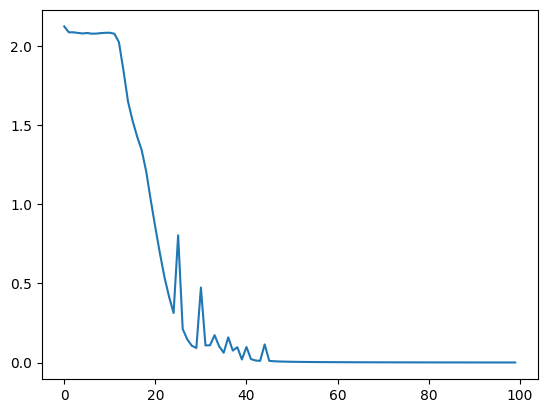

In [113]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [114]:
import random
experiments = 1000
correct = 0
for i in range(experiments):
    vals = [random.randint(0, 4), random.randint(0, 4)]
    sample = [vals[0]] + [stoi['+']] + [vals[1]] + [stoi['=']]

    embedded = emb[[[sample]]]

    # Forward pass
    Q = embedded @ Wq
    K = embedded @ Wk
    V = embedded @ Wv
    attention = Q @ K.transpose(-2, -1)
    # Mask
    # tril = torch.tril(torch.ones(block_size, block_size))
    # tril[tril==0] = -torch.inf
    # tril[tril==1] = 0
    # att_logits = (attention + tril) / h**0.5
    # More sofisticated way
    attention *= h**-0.5
    tril = torch.tril(torch.ones(block_size, block_size))
    att_logits = attention.masked_fill(tril[:block_size, :block_size] == 0, float('-inf'))
    # Softmax
    att_weights = torch.nn.functional.softmax(att_logits, dim=-1)
    # Attention output
    weighted_avg = att_weights @ V
    # We are only interested in predict in the loss for the last prediction, so we are ignoring the tokens behind '='
    x = weighted_avg[:,-1,:]
    # Final projection
    logits = x @ Wf + bf

    result = torch.nn.functional.softmax(logits, dim=-1).argmax().item()
    if sum(vals) == result:
        correct += 1

correct/experiments

1.0

In [131]:
with torch.no_grad():
    vals = [3, 2]
    sample = [vals[0]] + [stoi['+']] + [vals[1]] + [stoi['=']]

    embedded = emb[[[sample]]]

    # Forward pass
    Q = embedded @ Wq
    K = embedded @ Wk
    V = embedded @ Wv
    attention = Q @ K.transpose(-2, -1)
    # Mask
    tril = torch.tril(torch.ones(block_size, block_size))
    tril[tril==0] = -torch.inf
    tril[tril==1] = 0
    att_logits = (attention + tril) / h**0.5
    # Softmax
    att_weights = torch.nn.functional.softmax(att_logits, dim=-1)
    # Attention output
    weighted_avg = att_weights @ V
    # We are only interested in predict in the loss for the last prediction, so we are ignoring the tokens behind '='
    x = weighted_avg[:,-1,:]
    # Final projection
    logits = x @ Wf + bf

    result = torch.nn.functional.softmax(logits, dim=-1).argmax().item()
    print(result)

5


In [143]:
att_weights[0].sum(axis=(1))

tensor([1.0000, 1.0000, 1.0000, 1.0000])

tensor([0.4959, 0.0006, 0.4135, 0.0900])


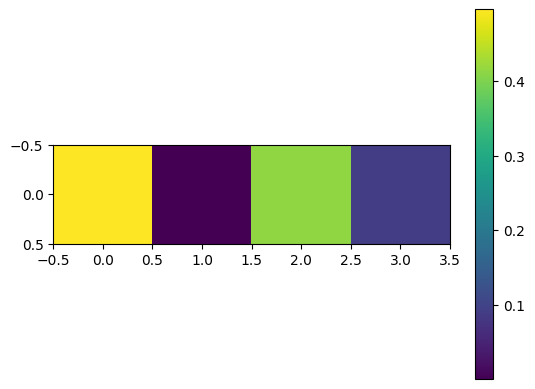

In [132]:
plt.imshow(att_weights.squeeze()[-1].view(1,4))
plt.colorbar()
print(att_weights.squeeze()[-1])

## Try adding any two digits

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Dataset
examples = 100000
def create_data():
    rand_nums = torch.randint(0, 10, (examples,2))
    x1 = torch.stack((torch.ones(examples)*stoi['<s>'], rand_nums[:,0], torch.ones(examples)*stoi['+'], rand_nums[:,1], torch.ones(examples)*stoi['=']), dim=1)
    x1 = x1.to(torch.int32)
    y1 = torch.tensor([0 if len(str(x)) == 1 else int(str(x)[0]) for x in rand_nums.sum(axis=1).numpy()])
    x2 = torch.stack((rand_nums[:,0], torch.ones(examples)*stoi['+'], rand_nums[:,1], torch.ones(examples)*stoi['='], y1), dim=1)
    x2 = x2.to(torch.int32)
    y2 = torch.tensor([x if len(str(x)) == 1 else int(str(x)[1]) for x in rand_nums.sum(axis=1).numpy()]).view(-1)
    x = torch.stack((x1, x2), dim=1).view(-1, 5)
    y = torch.stack((y1, y2), dim=0).view(-1)
    return x, y

data = create_data()

def get_batch():
    data_length = len(data[0])
    ix = torch.randint(0, data_length, (batch_size,))
    return data[0][ix], data[1][ix]


In [92]:
h = 8
batch_size = 128
emb_dim = 8
block_size = 5
lr = 1e-3

In [93]:
# Weights
emb = torch.randn(len(vocab), emb_dim).to(device)
# Positional embedding
pos_emb = torch.randn(block_size, emb_dim).to(device)

Wq = (torch.randn(emb_dim, h) / emb_dim**0.5).to(device)
Wk = (torch.randn(emb_dim, h) / emb_dim**0.5).to(device)
Wv = (torch.randn(emb_dim, h) / emb_dim**0.5).to(device)

Wf = (torch.randn(h, len(vocab) - 2) / h**0.5).to(device) # The valid outputs are digits only
bf = (torch.zeros(len(vocab) - 2)).to(device)

parameters = [emb, Wq, Wk, Wv, Wf, bf]
for p in parameters:
    p.requires_grad = True

lossi = []

for i in range(10000):
    x, y = get_batch()
    x = x.to(device)
    y = y.to(device)
    # Embed the tokens
    embedded = emb[x]
    embedded += pos_emb[torch.arange(block_size)]

    # Linear transformations to get K, Q, V
    Q = embedded @ Wq
    K = embedded @ Wk
    V = embedded @ Wv

    # Self-attention
    attention = Q @ K.transpose(-2, -1)
    # Mask
    tril = torch.tril(torch.ones(block_size, block_size)).to(device)
    tril[tril==0] = -torch.inf
    tril[tril==1] = 0
    att_logits = (attention + tril) / h**0.5
    # Softmax
    att_weights = torch.nn.functional.softmax(att_logits, dim=-1)
    # Attention output
    weighted_avg = att_weights @ V

    # We are only interested in predict in the loss for the last prediction, so we are ignoring the tokens behind '='
    x = weighted_avg[:,-1:,:].squeeze()

    # Final projection
    logits = x @ Wf + bf
    loss = torch.nn.functional.cross_entropy(logits, y, ignore_index=-1)
    lossi.append(loss.item())

    # Params update
    for p in parameters:
        p.grad = None

    loss.backward()
    for p in parameters:
        p.data -= lr * p.grad

print(loss.item())

1.8119394779205322


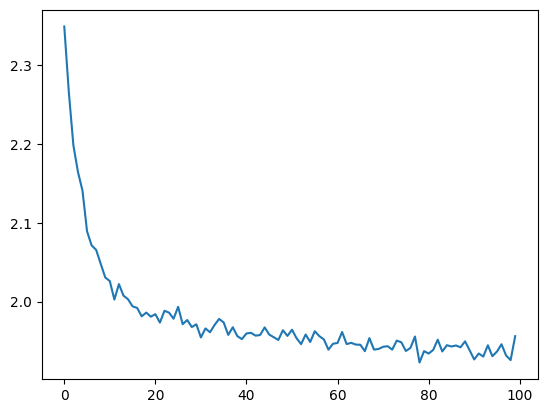

In [94]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))

In [100]:
import random
experiments = 1000
correct = 0
with torch.no_grad():
    for i in range(experiments):
        sample = torch.tensor([[[stoi['<s>']] + [vals[0]] + [stoi['+']] + [vals[1]] + [stoi['=']]]]).to(device)
        result = 0
        vals = [random.randint(0, 10), random.randint(0, 10)]
        while sample.shape[-1] < 7:
            embedded = emb[sample[:,:,-block_size:]]

            # Forward pass
            Q = embedded @ Wq
            K = embedded @ Wk
            V = embedded @ Wv
            attention = Q @ K.transpose(-2, -1)
            # Mask
            tril[tril==0] = -torch.inf
            tril[tril==1] = 0
            att_logits = (attention + tril) / h**0.5
            # Softmax
            att_weights = torch.nn.functional.softmax(att_logits, dim=-1)
            # Attention output
            weighted_avg = att_weights @ V
            # We are only interested in predict in the loss for the last prediction, so we are ignoring the tokens behind '='
            x = weighted_avg[:,-1,:].squeeze()
            # Final projection
            logits = x @ Wf + bf

            if sample.shape[-1] == 5:
                result += torch.nn.functional.softmax(logits, dim=-1).argmax().item()*10
            if sample.shape[-1] == 6:
                result += torch.nn.functional.softmax(logits, dim=-1).argmax().item()
            sample = torch.concat((sample, torch.tensor(([[[result]]])).to(device)), dim=-1)
        if sum(vals) == result:
            correct += 1
            print(vals, result)

correct/experiments

[0, 0] 0
[0, 0] 0
[0, 0] 0
[0, 0] 0
[0, 0] 0


0.005